# GMAPS Data Analysis

By: Rodrigo Hernández Mota

This document performs an automated exploratory data analysis of google maps raw dataset. 

In [129]:
%matplotlib inline

import random
import numpy as np
import pandas as pd
#import geopandas as gp
import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap
from util.data_operations import get_dataset

## Load data and description

In [2]:
df = get_dataset()
print("Data shape: {}".format(df.shape))

Data shape: (511365, 15)


In [3]:
df.head()

,EXITING_VEHICLE,IN_VEHICLE,ON_BICYCLE,ON_FOOT,RUNNING,STILL,TILTING,UNKNOWN,WALKING,accuracy,alt,lat,likely_activity,lng,timestamp
0,0,57,0,0,0,43,0,0,0,24,1561.0,20.712508,IN_VEHICLE,-103.410124,1507742288644
1,0,30,0,0,0,21,0,50,0,24,1561.0,20.712508,UNKNOWN,-103.410124,1507742168348
2,0,30,0,0,0,21,0,50,0,24,1561.0,20.712508,UNKNOWN,-103.410124,1507742168348
3,0,54,0,0,0,46,0,0,0,24,1561.0,20.712508,IN_VEHICLE,-103.410124,1507742046707
4,0,26,0,0,0,24,0,50,0,23,1561.0,20.712508,UNKNOWN,-103.410124,1507741926568


In [4]:
print("Columns and data types: \n\n" + str(df.dtypes))

Columns and data types: 

EXITING_VEHICLE      int64
IN_VEHICLE           int64
ON_BICYCLE           int64
ON_FOOT              int64
RUNNING              int64
STILL                int64
TILTING              int64
UNKNOWN              int64
WALKING              int64
accuracy             int64
alt                float64
lat                float64
likely_activity     object
lng                float64
timestamp           object
dtype: object


**OVERVIEW**

Each row in the datafame represents a sample given by Google Maps. This sample contains geographic data (coordinates), temporal data (timestamp) and activity detected. 

**ACTIVITY TYPES**

At a given palce and time, Google's algorithms can detect a set of activities (denoted in the dataframe as the UPPERCASE columns). The value (int) of this columns represents the likelihood (probability) of occurence. The default activity when all columns are zero or less than 5 is UNKNOWN. 

The column named _likely_activity_ contains a string value representing the most probable activity for a given sample.

**GEOGRAPHIC DATA**

The geographic coordinates _lat_ (latitude), _lng_ (longitude) are aloways available for each data sample. To denote the quality of this data, the column _accuracy_ provides an insightful metric. Furthermore, the dataset contains the _altitude_ value.

**TEMPORAL DATA**

Each datapoint contains a timestamp measured as ms. 

## TIMESTAMP

In [5]:
df["timestamp"] = df.timestamp.astype(int).values
df = df.sort_values("timestamp")

We determine the frequency of the samples by calculating the time difference of the ordered datapoints. 

In [6]:
def get_diff(df, name="diff"):
    return pd.DataFrame(
        df.timestamp.values[1:] - df.timestamp.values[:-1],
        columns=[name])

get_diff(df).describe()

,diff
count,5.113640e+05
mean,1.799271e+05
std,8.288531e+05
min,0.000000e+00
25%,0.000000e+00
50%,6.114800e+04
75%,1.212120e+05
max,1.497735e+08


As it can be seen, the data contains several datapoints with 0 time-length. It can be assume this corresponds to the need of capture a more detailed dataset when the user is doing a relevant activity (such as driving). 

To test this assumption we can calculate the same time-difference while querying the dataframe with different activites. 

In [7]:
pd.concat(
    [
        get_diff(df.query("IN_VEHICLE > 50"), "diff_driving").describe(),
        get_diff(df.query("STILL > 50"), "diff_still").describe()
    ],
    axis=1
)

,diff_driving,diff_still
count,5.552400e+04,2.617080e+05
mean,1.656890e+06,3.515665e+05
std,9.201704e+06,1.217206e+06
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,6.843850e+04
75%,1.208030e+05,2.253178e+05
max,3.846063e+08,1.553336e+08


The time difference while driving seems to present a much high sampling frequency than the time difference while being still (by seeing the values up to percentile 75%).

## GEOGRAPHIC COORDINATES

In [43]:
def plot_in_map(df, region):
    bmap = Basemap(projection='stere',
               lon_0=df.lng.mean(),
               lat_0=df.lat.mean(),
               lat_ts=0,
               llcrnrlat=region["low_limit"].get("lat"),
               urcrnrlat=region["upper_limit"].get("lat"),
               llcrnrlon=region["low_limit"].get("lng"),
               urcrnrlon=region["upper_limit"].get("lng"),
               rsphere=6371200.,resolution='l',area_thresh=10000
              )
    bmap.drawcoastlines()
    bmap.drawstates()
    bmap.drawcountries()


    x, y = bmap(df.lng.values, df.lat.values)

    bmap.scatter(x, y, marker='.',color='g')
    plt.show()

In [44]:
mexico_usa_frame = {
    "low_limit": {
        "lat":9.968851 ,
        "lng": -124.189453
    },
    "upper_limit": {
        "lat": 60,
        "lng": -63.017578
    }
}

europe_frame = {}

/home/rhdzmota/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/rhdzmota/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


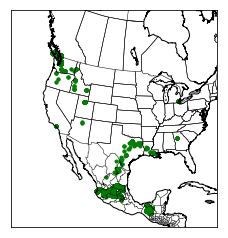

In [46]:
plot_in_map(df, mexico_usa_frame)

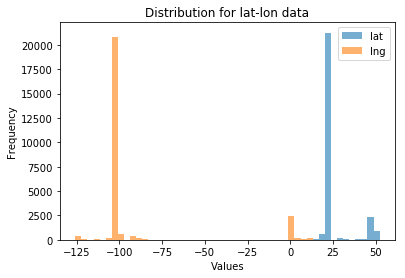

In [24]:
df[["lat", "lng"]].sample(frac=0.05).plot.hist(bins=50, alpha=0.6)
plt.title("Distribution for lat-lon data")
plt.xlabel("Values")
plt.show()

In this histogram we can see that the mayority of the datapoints are around a specific coodinate pair.

## Distance

In [158]:
def degree_to_radian(degree):
    return 2 * degree * np.pi / 360


def harversine(x):
    initial_coord, final_coord = x[["initial_lat", "initial_lng"]].values, x[["final_lat", "final_lng"]].values
    r = 6371
    initial_rads = list(map(degree_to_radian, initial_coord))
    final_rads = list(map(degree_to_radian, final_coord))
    delta_phi = final_rads[0] - initial_rads[0]
    delta_lambda = initial_rads[1] - final_rads[1]
    h = np.power(np.sin(delta_phi/2), 2) + \
        np.cos(initial_rads[0]) * np.cos(final_rads[0]) * \
        np.power(np.sin(delta_lambda/2), 2)
    return 2*r*np.arcsin(np.sqrt(h))

In [33]:

latlon = pd.concat([
    df[["lat", "lng"]][1:].reset_index(drop=True),
    df[["lat", "lng"]][:-1].reset_index(drop=True)], 
    1)

latlon.columns = ["initial_lat", "initial_lng", "final_lat", "final_lng"]
latlon.head()

,initial_lat,initial_lng,final_lat,final_lng
0,20.690132,-103.445102,20.690132,-103.445102
1,20.690132,-103.445102,20.690132,-103.445102
2,20.690401,-103.446044,20.690132,-103.445102
3,20.690031,-103.445328,20.690401,-103.446044
4,20.690232,-103.444875,20.690031,-103.445328


In [43]:
latlon["distance"] = latlon.apply(harversine, 1)

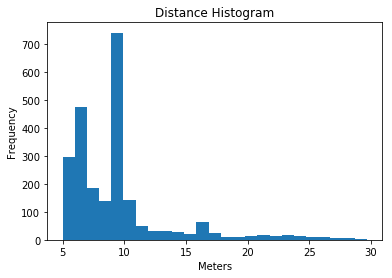

In [58]:
latlon.query("5 < distance and distance < 30").distance.plot.hist(bins=25)
plt.title("Distance Histogram")
plt.xlabel("Meters")
plt.show()

In [62]:
df["distance"] = [0] + list(latlon.distance.values)

## TODO: MORE ANALYSIS

In [162]:
# here

## Trips

In [105]:
driving_df = df.query("likely_activity == 'IN_VEHICLE'").copy()
driving_df.head()

,EXITING_VEHICLE,IN_VEHICLE,ON_BICYCLE,ON_FOOT,RUNNING,STILL,TILTING,UNKNOWN,WALKING,accuracy,alt,lat,likely_activity,lng,timestamp,distance
511357,0,37,0,0,0,32,0,31,0,39,NaN,20.690218,IN_VEHICLE,-103.445684,1415734834967,0.000000
511356,0,42,8,0,0,16,0,35,0,27,NaN,20.690031,IN_VEHICLE,-103.445328,1415734960986,0.042494
511344,0,33,6,2,0,6,0,2,0,27,NaN,20.690031,IN_VEHICLE,-103.445328,1415735715772,0.070271
511315,0,27,4,6,0,16,0,2,0,27,NaN,20.689784,IN_VEHICLE,-103.444707,1415739466127,0.000000
511293,0,18,12,2,0,10,0,2,0,27,NaN,20.690032,IN_VEHICLE,-103.445328,1415742128872,0.000000


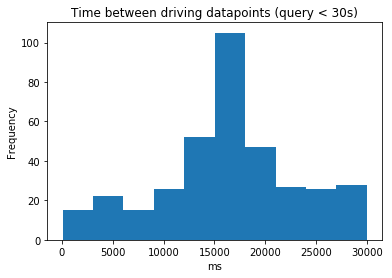

In [106]:
driving_df["delta_time"] = [0] + list(driving_df.timestamp.values[1:] - driving_df.timestamp.values[:-1])

driving_df.query("0 < delta_time and delta_time < 30000").delta_time.plot.hist()
plt.title("Time between driving datapoints (query < 30s)")
plt.xlabel("ms")
plt.show()

In [123]:
driving_df["trip_id"] = np.cumsum(driving_df.delta_time.values > 7*60*1000)
print("Number of unique trips: {}".format(len(driving_df.trip_id.unique())))

Number of unique trips: 9089


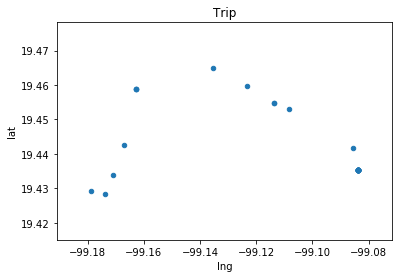

In [146]:
tripid = 9001 # random.choice(driving_df.trip_id.unique())
driving_df.query("trip_id == {}".format(9001)).plot.scatter(x="lng", y="lat")
plt.title("Trip")
plt.show()

In [197]:
def distance_df(trip_data):
    temp = pd.concat([
        trip_data[["lat", "lng"]][1:].reset_index(drop=True),
        trip_data[["lat", "lng"]][:-1].reset_index(drop=True)], 
        1)
    temp.columns = ["initial_lat", "initial_lng", "final_lat", "final_lng"]
    return temp

trips = pd.DataFrame([], columns=["id", "distance", "time", "lat", "lng"])

ids = []
distance = []
time = []
lats = []
lngs = []
deleted_trips = 0
for trip in driving_df.trip_id.unique():
    trip_data = driving_df.query("trip_id == {}".format(trip))
    if len(trip_data)  < 5:
        deleted_trips += 1
        continue
    distance.append(distance_df(trip_data).apply(harversine, 1).sum())
    time.append(trip_data.timestamp.values[-1] - trip_data.timestamp.values[0])
    ids.append(trip)
    lats.append(trip_data.lat.values)
    lngs.append(trip_data.lng.values)
    
trips["id"] = ids
trips["distance"] = distance
trips["time"] = time
trips["lat"] = lats
trips["lng"] = lngs

In [203]:
print("Valid trips: {}".format(len(trips)))
trips["n_datapoints"] = trips.apply(lambda x: len(x["lat"]), 1).values
trips.head(10)

Valid trips: 2689


,id,distance,time,lat,lng,n_datapoints
0,8,0.841810,654117,"[20.6904019, 20.6901424, 20.6901424, 20.690142...","[-103.4460443, -103.4455219, -103.4455219, -10...",6
1,17,1.027902,656394,"[20.6079754, 20.6144566, 20.6144566, 20.614456...","[-103.4168693, -103.4239116, -103.4239116, -10...",5
2,21,0.000000,623161,"[20.6904012, 20.6904012, 20.6904012, 20.690401...","[-103.4460442, -103.4460442, -103.4460442, -10...",5
3,24,0.061337,800407,"[20.6062196, 20.6063649, 20.6062775, 20.606017...","[-103.4157996, -103.4158305, -103.415802, -103...",5
4,28,0.000000,767679,"[20.6080048, 20.6080048, 20.6080048, 20.608004...","[-103.4158311, -103.4158311, -103.4158311, -10...",6
5,37,7.958452,500853,"[20.6899792, 20.6899792, 20.6899792, 20.652865...","[-103.4450515, -103.4450515, -103.4450515, -10...",5
6,47,0.000000,830711,"[20.6075488, 20.6075488, 20.6075488, 20.607548...","[-103.4166765, -103.4166765, -103.4166765, -10...",6
7,61,0.000000,764567,"[20.6901821, 20.6901821, 20.6901821, 20.690182...","[-103.4453106, -103.4453106, -103.4453106, -10...",6
8,81,9.578160,803325,"[20.6901701, 20.6901701, 20.6901701, 20.690170...","[-103.4453043, -103.4453043, -103.4453043, -10...",5
9,92,0.010371,867887,"[20.6977508, 20.6977148, 20.6977111, 20.697693...","[-103.3844026, -103.3844142, -103.384399, -103...",7


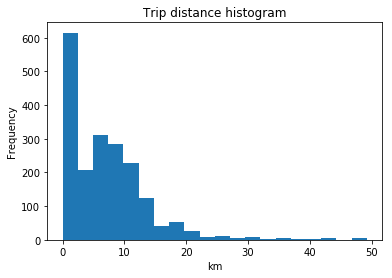

In [184]:
# trip distance

trips.query("0 < distance and distance < 50").distance.plot.hist(bins=20)
plt.title("Trip distance histogram")
plt.xlabel("km")
plt.show()

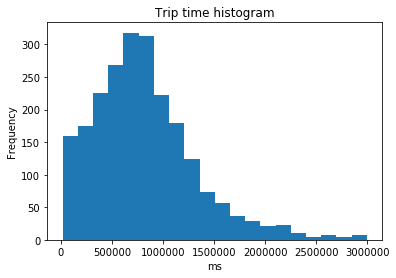

In [195]:
# trip distance

trips.query("0 < time and time < 3000000").time.plot.hist(bins=20)
plt.title("Trip time histogram")
plt.xlabel("ms")
plt.show()